<a href="https://colab.research.google.com/github/subod4/Simulation-and-Modeling-Projects/blob/main/Hospital_ER_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy

Patient 1 arrived at 4.34 minutes.
Patient 1 is being checked in by a nurse at 4.34 minutes.
Patient 2 arrived at 4.67 minutes.
Patient 2 is being checked in by a nurse at 4.67 minutes.
Patient 3 arrived at 4.72 minutes.
Patient 4 arrived at 5.20 minutes.
Patient 5 arrived at 6.76 minutes.
Patient 6 arrived at 10.56 minutes.
Patient 7 arrived at 13.20 minutes.
Patient 8 arrived at 17.20 minutes.
Patient 9 arrived at 18.08 minutes.
Patient 10 arrived at 19.30 minutes.
Patient 11 arrived at 20.01 minutes.
Patient 12 arrived at 20.26 minutes.
Patient 13 arrived at 20.29 minutes.
Patient 14 arrived at 21.21 minutes.
Patient 1 treated in 18.44 minutes (Severity: Medium)
Patient 1 is being treated by a doctor at 22.77 minutes.
Patient 3 is being checked in by a nurse at 22.77 minutes.
Patient 2 treated in 20.59 minutes (Severity: Medium)
Patient 2 is being treated by a doctor at 25.26 minutes.
Patient 4 is being checked in by a nurse at 25.26 minutes.
Patient 15 arrived at 26.83 minutes.
Pat

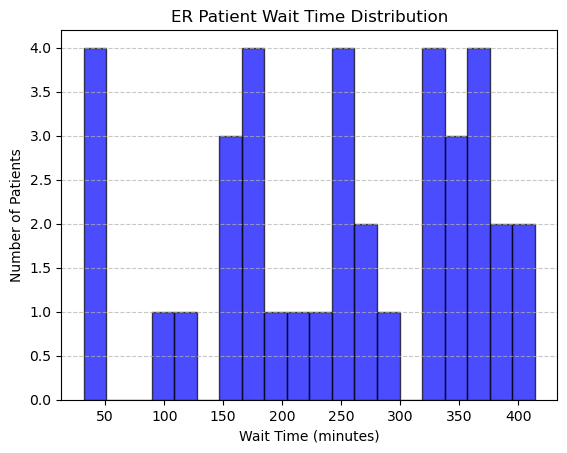

In [3]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# Simulation Parameters
NUM_DOCTORS = 3   # Number of available doctors
NUM_NURSES = 2    # Number of available nurses
ARRIVAL_RATE = 50  # Patients per hour
SIM_TIME = 8 * 60  # 8 hours (in minutes)

# Severity Levels
SEVERITY_LEVELS = {"Low": (5, 15), "Medium": (15, 30), "High": (30, 60)}

# Store wait times for analysis
wait_times = []

# Initialize random generator for true randomness
rng = np.random.default_rng()

class HospitalER:
    def __init__(self, env, num_doctors, num_nurses):
        self.env = env
        self.doctor = simpy.Resource(env, num_doctors)
        self.nurse = simpy.Resource(env, num_nurses)

    def treat_patient(self, patient_id, severity):
        treatment_time = rng.uniform(*SEVERITY_LEVELS[severity])
        yield self.env.timeout(treatment_time)
        print(f"Patient {patient_id} treated in {treatment_time:.2f} minutes (Severity: {severity})")

def patient_generator(env, er):
    patient_id = 0
    while True:
        patient_id += 1
        arrival_interval = rng.exponential(60 / ARRIVAL_RATE)  # Convert rate to minutes
        yield env.timeout(arrival_interval)
        env.process(patient_flow(env, patient_id, er))

def patient_flow(env, patient_id, er):
    arrival_time = env.now
    print(f"Patient {patient_id} arrived at {arrival_time:.2f} minutes.")

    severity = rng.choice(["Low", "Medium", "High"])  # Assign severity

    # Check-in with nurse
    with er.nurse.request() as request:
        yield request
        print(f"Patient {patient_id} is being checked in by a nurse at {env.now:.2f} minutes.")
        yield env.process(er.treat_patient(patient_id, severity))

    # Treatment by doctor
    with er.doctor.request() as request:
        yield request
        print(f"Patient {patient_id} is being treated by a doctor at {env.now:.2f} minutes.")
        yield env.process(er.treat_patient(patient_id, severity))

    wait_time = env.now - arrival_time
    wait_times.append(wait_time)
    print(f"Patient {patient_id} finished at {env.now:.2f} minutes. Wait time: {wait_time:.2f} minutes.")

# Run Simulation
env = simpy.Environment()
hospital = HospitalER(env, NUM_DOCTORS, NUM_NURSES)
env.process(patient_generator(env, hospital))
env.run(until=SIM_TIME)

# Plot Wait Time Distribution
plt.hist(wait_times, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Wait Time (minutes)")
plt.ylabel("Number of Patients")
plt.title("ER Patient Wait Time Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
